
# Tutorial: Tail Segmentation 

**The following notebook illustrate the `TailSegmentation` class.**



* Loading dependencies

In [1]:
from IPython.display import SVG, display

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from megabouts.tracking_data.tracking_data import TrackingConfig
from megabouts.tracking_data.load_example import load_example_data
from megabouts.tracking_data.tracking_data import FullTrackingData

from megabouts.preprocessing.tail_preprocessing import TailPreprocessingConfig
from megabouts.preprocessing.tail_preprocessing import TailPreprocessingResult
from megabouts.preprocessing.tail_preprocessing import TailPreprocessing

from megabouts.segmentation.segmentation_config import TailSegmentationConfig
from megabouts.segmentation.segmentation import TailSegmentation
from megabouts.segmentation.segmentation import SegmentationFactory
from megabouts.segmentation.segmentation import SegmentationResult

## Loading Data and Preprocessing

* TrackingConfig and TrackingData similar to [tutorial_Tail_Preprocessing](./tutorial_Tail_Preprocessing.ipynb)

In [2]:
df_recording, fps, mm_per_unit = load_example_data('fulltracking_posture')

tracking_cfg = TrackingConfig(fps=fps, tracking='full_tracking')

head_x = df_recording['head_x'].values*mm_per_unit
head_y = df_recording['head_y'].values*mm_per_unit
head_yaw = df_recording['head_angle'].values
tail_angle = df_recording.filter(like='tail_angle').values

tracking_data = FullTrackingData.from_posture(head_x = head_x,
                                              head_y = head_y,
                                              head_yaw = head_yaw,
                                              tail_angle = tail_angle)

tail_preprocessing_cfg = TailPreprocessingConfig(fps=tracking_cfg.fps)

tail_preprocessing_cfg = TailPreprocessingConfig(fps=tracking_cfg.fps,
                                                 num_pcs=4,
                                                 savgol_window_ms=15,
                                                 tail_speed_filter_ms = 100,
                                                 tail_speed_boxcar_filter_ms = 14
                                                 )
tail_df_input = tracking_data.tail_df
tail = TailPreprocessing(tail_preprocessing_cfg).preprocess_tail_df(tail_df_input)


In [3]:
tail.df.head(5)

angle                                                              \
   segments                                                               
          0         1         2         3         4         5         6   
0 -0.101865 -0.092813 -0.107645 -0.110575 -0.047699 -0.145887 -0.130414   
1 -0.082618 -0.087957 -0.096951 -0.092459 -0.119418 -0.043354 -0.099788   
2 -0.093377 -0.095235 -0.094292 -0.105936 -0.073785 -0.084193 -0.144378   
3 -0.092590 -0.083650 -0.100938 -0.088223 -0.097370 -0.099559 -0.101538   
4 -0.086849 -0.081982 -0.096705 -0.118475 -0.046264 -0.136459 -0.115412   

                           ... angle_smooth                                \
                           ...     segments                                 
          7         8   9  ...            2         3         4         5   
0 -0.058892 -0.128705 NaN  ...    -0.086812 -0.085880 -0.077907 -0.083591   
1 -0.101741 -0.171555 NaN  ...    -0.081511 -0.083338 -0.078373 -0.085253   
2 -0.112398 -0.042585 NaN  ...    -0.077037 -0.081058 -0.078500 -0.086296   
3 -0.091272 -0.021459 NaN  ...    -0.073390 -0.079040 -0.078286 -0.086720   
4 -0.085300 -0.015487 NaN  ...    -0.070570 -0.077285 -0.077732 -0.086525   

                                          vigor no_tracking  
                                                             
          6         7         8         9                    
0 -0.072974 -0.078165 -0.129616  0.000359   NaN        True  
1 -0.074040 -0.073428 -0.106065  0.000494   NaN        True  
2 -0.074570 -0.069208 -0.086540  0.000602   NaN        True  
3 -0.074562 -0.065506 -0.071041  0.000682   NaN        True  
4 -0.074018 -0.062321 -0.059569  0.000734   NaN        True  

[5 rows x 32 columns]

# Segmentation using tail vigor

In [4]:
tail_vigor = tail.vigor
tail_segmentation_cfg = TailSegmentationConfig(fps = tracking_cfg.fps)
segmentation_function = SegmentationFactory.get_segmenter(tail_segmentation_cfg)
segments = segmentation_function.segment_from_tail(tail_vigor)

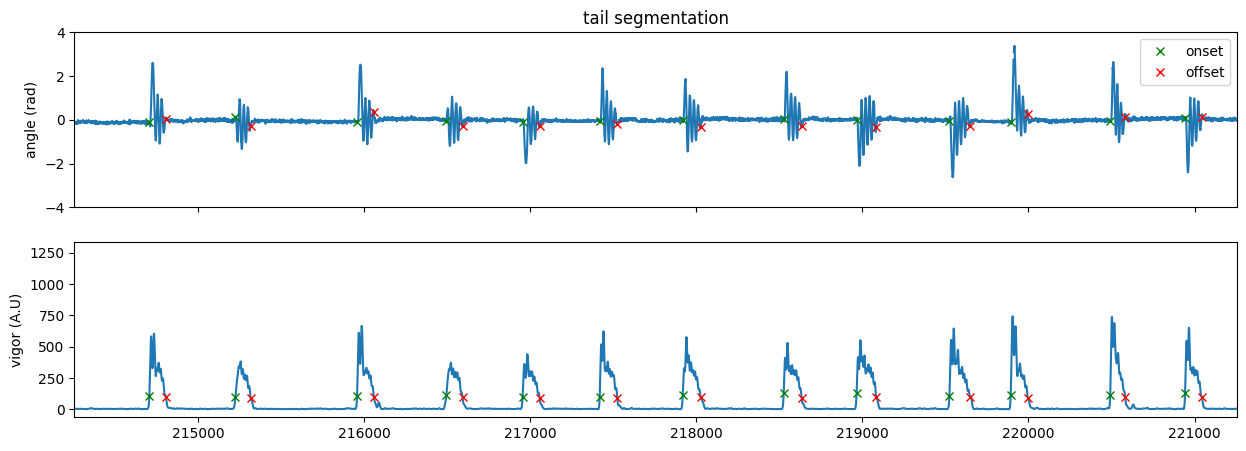

In [5]:
fig,ax = plt.subplots(2,1,figsize=(15,5),sharex=True)

x = tracking_data._tail_angle[:,7]
ax[0].plot(x)
ax[0].plot(segments.onset, x[segments.onset], "x",color='green',label='onset')
ax[0].plot(segments.offset, x[segments.offset], "x",color='red',label='offset')
ax[0].set_ylim(-4,4)
ax[0].legend()
ax[0].set(title='tail segmentation',ylabel='angle (rad)',ylim=(-4,4))

x = tail_vigor
ax[1].plot(x)
ax[1].plot(segments.onset, x[segments.onset], "x",color='green')
ax[1].plot(segments.offset, x[segments.offset], "x",color='red')
ax[1].set(ylabel='vigor (A.U)')

t = np.arange(tracking_data.T)/tracking_cfg.fps
IdSt = np.random.randint(tracking_data.T)
Duration = 10*tracking_cfg.fps
ax[1].set_xlim(IdSt,IdSt+Duration)

plt.show()

In [6]:
# Number of bouts as function of threshold:
thresh_list = np.linspace(50,800,100)
num_peaks = np.zeros_like(thresh_list)
tail_vigor = tail.vigor

for i,thresh in enumerate(thresh_list):
    tail_segmentation_cfg = TailSegmentationConfig(fps = tracking_cfg.fps,
                                                   threshold=thresh)
    segmentation_function = SegmentationFactory.get_segmenter(tail_segmentation_cfg)
    segments = segmentation_function.segment_from_tail(tail_vigor)
    num_peaks[i] = len(segments.onset)


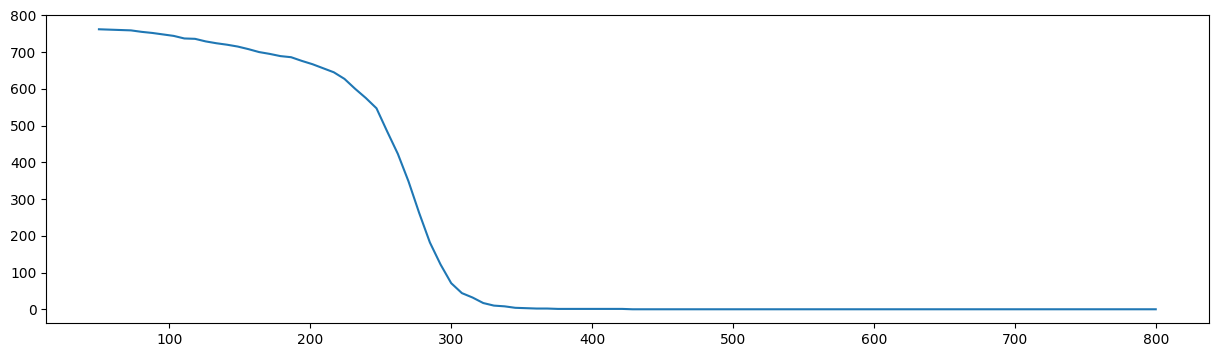

In [7]:
plt.figure(figsize=(15,4))
plt.plot(thresh_list,num_peaks)
plt.show()